In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

import re
import numpy as np

class DataFrameTfidfVectorizer(TfidfVectorizer):

  def __init__(self, col, prefix=None, input='content', encoding='utf-8',
               decode_error='strict', strip_accents=None, lowercase=True,
               preprocessor=None, tokenizer=None, analyzer='word',
               stop_words=None, token_pattern=r"(?u)\b\w\w+\b",
               ngram_range=(1, 1), max_df=1.0, min_df=1,
               max_features=None, vocabulary=None, binary=False,
               dtype=np.int64, norm='l2', use_idf=True, smooth_idf=True,
               sublinear_tf=False):
      super(DataFrameTfidfVectorizer, self).__init__(
          input=input, encoding=encoding, decode_error=decode_error,
          strip_accents=strip_accents, lowercase=lowercase,
          preprocessor=preprocessor, tokenizer=tokenizer, analyzer=analyzer,
          stop_words=stop_words, token_pattern=token_pattern,
          ngram_range=ngram_range, max_df=max_df, min_df=min_df,
          max_features=max_features, vocabulary=vocabulary, binary=binary,
          dtype=dtype)

      self.col = col
      self.prefix = prefix or col
      
  def treat_special_char(self, c):
    try:
      encoding = chardet.detect(str(c))['encoding'] or "KOI8-R"
      return '0' if c.isdigit() else c.decode(encoding)
    except:        
      return '9'

  def treat_special_chars(self, col):
    col.fillna("null", inplace=True)
    col = [''.join([self.treat_special_char(c) for c in list(n)]) 
           for n in col.values]
    return col

  def fit(self, dataframe, y=None):
    dataframe = dataframe.copy()
    dataframe[self.col] = self.treat_special_chars(dataframe[self.col])
    super(DataFrameTfidfVectorizer, self).fit(dataframe[self.col])
    return self

  def fit_transform(self, dataframe, y=None):
    dataframe = dataframe.copy()
#     dataframe[self.col] = self.treat_special_chars(dataframe[self.col])
    field_matrix = super(DataFrameTfidfVectorizer, self).fit_transform(dataframe[self.col])
    features_names = map(lambda f: "_".join([self.prefix,f]), super(DataFrameTfidfVectorizer, self).get_feature_names())
    field_df = pd.DataFrame(field_matrix.A, columns=features_names)

    dataframe = dataframe.join(field_df)

    return dataframe

  def transform(self, dataframe, copy=True):
    dataframe = dataframe.copy()
#     dataframe[self.col] = self.treat_special_chars(dataframe[self.col])
    field_matrix = super(DataFrameTfidfVectorizer, self).transform(dataframe[self.col])
    features_names = map(lambda f: "_".join([self.prefix,f]), super(DataFrameTfidfVectorizer, self).get_feature_names())
    field_df = pd.DataFrame(field_matrix.A, columns=features_names)

    dataframe = dataframe.join(field_df)

    return dataframe

class TextToLowerCase(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X.loc[:, c] = [t.lower() for t in X[c].values]
    return X


class NumberOfWords(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X.loc[:, "number_of_words_in_"+c] = [len(t.split(' ')) for t in X[c].values]
    return X

class NumberNonAlphaNumChars(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X.loc[:, "number_of_non_alphanum_in_"+c] = [len(re.sub(r"[\w\d]","", t)) for t in X[c].values]
    return X


class NumberUpperCaseChars(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X.loc[:, "number_of_upper_case_chars_in_"+c] = [len(re.sub(r"[^A-Z]","", t)) for t in X[c].values]
    return X


class NumberCamelCaseWords(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X.loc[:, "number_of_camel_case_words_in_"+c] = [len(re.findall(r"^[A-Z][a-z]|\s[A-Z][a-z]", t)) 
                                                 for t in X[c].values]
    return X


class NumberOfMentions(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X.loc[:, "number_of_mentions_in_"+c] = [len(re.findall(r"\s@[a-zA-Z]",t)) 
                                                 for t in X[c].values]
    return X

class NumberOfHashtags(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X.loc[:, "number_of_mentions_in_"+c] = [len(re.findall(r"#[a-zA-Z\d]+",t)) 
                                                 for t in X[c].values]
    return X
  
class NumberOfURLs(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X.loc[:, "number_of_urls_in_"+c] = [len(re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',t)) 
                                                 for t in X[c].values]
    return X

class NumberOfPeriods(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X.loc[:, "number_of_periods_in_"+c] = [len(t.split(". ")) 
                                        for t in X[c].values]
    return X


class AvgWordsPerPeriod(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X.loc[:, "avg_words_per_period_in_"+c] = [np.mean([len(p.split(" ")) for p in t.split(". ")]) 
                                            for t in X[c].values]
    return X

class DropColumnsTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, cols):
    self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X.drop([c], axis=1, inplace=True)
    return X


class NumpyArrayTransformer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X = X.reindex_axis(sorted(X.columns), axis=1)
    X.fillna(0, inplace=True)
    return np.asarray(X)
  
class HashtagDistanceTransformer(BaseEstimator, TransformerMixin):

  def __init__(self, model, cols):
    self.model = model
    self.cols = cols
  
  def fit(self, model, X, y=None):
    return self
  
  def transform(self, X, y=None):
    for c in self.cols:
      if c in X:
        X = X.join(X[c].apply(lambda value: self.hashtags_distance(self.model, value)))
        print X.columns
    return X
  
  def hashtags_distance(self, model, value):
    if value is None: return {'min_distance': -999, 'max_distance': -999, 'avg_distance': -999}
    
    hashtags = re.findall(r"#[a-zA-Z\d]+", value)
                          
    _min, _max, _avg = self.distance(model, hashtags)
                            
    return pd.Series({'min_distance': _min, 'max_distance': _max, 'avg_distance': _avg})

  def distance(self, model, array):
    _itens = 0
    _sum = 0
    _min = 1000
    _max = 0

    if len(array) <= 1:
        return 0,0,0

    for i1 in range(0, len(array)):
        for i2 in range(0, len(array)):
            if i1 == i2: 
                continue

            r = 0
            try:
              r = model.similarity(array[i1], array[i2])
              _sum += r
              if r > _max:
                  _max = r
              if r < _min: 
                  _min = r

              _itens += 1
            except:
              continue
            
    return _min, _max, _sum/_itens

class Debugger(BaseEstimator, TransformerMixin):
  def __init__(self, name=""):
      self.name = name

  def fit(self, X, y=None):
      return self

  def transform(self, X, y=None):
      print self.name, '-', ctime(), X.shape
      return X

import matplotlib as plt
import numpy as np
 
def plot_feature_scores(coef, vocab, index=0):
    markers = ["o", "x"]
    
    figsize(20,8)

    important = np.argsort(np.abs(coef))[-50:]
    important_feature_names = np.array([vocab[idx] for idx in important])
    important_feature_values = coef[important]
    inds = np.argsort(important_feature_values)[::-1]
    important_feature_names = important_feature_names[inds]
    important_feature_values = important_feature_values[inds]
    ylabel("weight")

    ax = plt.gca()
    ax.set_xticks(np.arange(len(important_feature_values)))
    labels = ax.set_xticklabels(important_feature_names)
    plt.setp(labels, rotation=90)
    #plt.plot(important_feature_values, marker="o", c=cm.jet)
    plt.scatter(np.arange(len(important_feature_values)), important_feature_values, c=important_feature_values,marker=markers[index], cmap=cm.autumn)
    print("done")

In [18]:
from os import listdir
from os.path import isfile, join
docLabels = []
docLabels = [f for f in listdir("data/instagram_activities/") if '.csv' in f]

print 'documents:', len(docLabels)
print docLabels

documents: 11
['instagram_activities.csv.0', 'instagram_activities.csv.1', 'instagram_activities.csv.10', 'instagram_activities.csv.2', 'instagram_activities.csv.3', 'instagram_activities.csv.4', 'instagram_activities.csv.5', 'instagram_activities.csv.6', 'instagram_activities.csv.7', 'instagram_activities.csv.8', 'instagram_activities.csv.9']


In [19]:
import pandas as pd

ratings = pd.read_csv('data/instagram_ratings.csv', header=None)
ratings.columns = ['id', 'bool_feedback', 'body', 'feedback', 'rule_id']
ratings.ix[pd.isnull(ratings['feedback']), 'feedback'] = 'good'

print '- - - length:', len(ratings)

- - - length: 3700


In [4]:
import gensim

model = gensim.models.Word2Vec.load('1M_10epochs_hashtags')

model.init_sims(replace=True)

Couldn't import dot_parser, loading of dot files will not be possible.


In [20]:
data = ratings[ratings['feedback'].isin(['spam'])]
data = data.append(ratings[ratings['feedback'].isin(['good'])].head(len(data)))

data.loc[:, 'result'] = data.loc[:, 'feedback'].isin(['spam'])
data.loc[:, 'result'] = data.result.astype(int)

print data.groupby(['result']).agg(['count'])

print 'items:', len(data)

data = data.dropna(subset=['body'])
data.drop(['id', 'bool_feedback', 'feedback', 'rule_id'], axis=1, inplace=True)

          id bool_feedback  body feedback rule_id
       count         count count    count   count
result                                           
0        307           307   299      307     307
1        307           307   307      307     307
items: 614


In [21]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix

from time import time, ctime

pipeline = Pipeline([
  ('body_lowercase', TextToLowerCase(cols=['body'])),
  ("debugger1", Debugger('body')),
  ('number_mentions', NumberOfMentions(cols=['body'])),
  ('number_hashtags', NumberOfHashtags(cols=['body'])),
  ('number_periods', NumberOfPeriods(cols=['body'])),
  ('number_urls', NumberOfURLs(cols=['body'])),
  ("debugger2", Debugger('entities')),
  ('number_words', NumberOfWords(cols=['body'])),
  ('number_camel_words', NumberCamelCaseWords(cols=['body'])),
  ('number_words_per_period', AvgWordsPerPeriod(cols=['body'])),        
  ("debugger3", Debugger('words')),
  ('number_uppercase_chars', NumberUpperCaseChars(cols=['body'])),
  ('number_punctuation_chars', NumberNonAlphaNumChars(cols=['body'])),
  ("debugger4", Debugger('chars')),
  ('semantic_distance', HashtagDistanceTransformer(model, ['body'])),
  ("debugger5", Debugger('distance')),
  ("body_tfidf", DataFrameTfidfVectorizer(col=['body'], 
                          prefix="body",
                          ngram_range=(1, 3), 
                          analyzer="word",
                          binary=True, #False
#                           min_df = 2,
                          max_features = 50)),
  ("debugger6", Debugger('tdidf')),
  ("drop_text_cols", DropColumnsTransformer(['body'])),
  ("nparray", NumpyArrayTransformer()),
  ('tree', DecisionTreeClassifier(max_depth = 5, min_samples_split = 2))
])

parameters = {
#     'body_tfidf__min_df': (2, 5, 10),
#     'body_tfidf__max_features': (50, 500, 1000),
#     'tree__max_depth': (5, 10),  # unigrams or bigrams
#     'tree__min_samples_split': (2, 5)
}

k_fold = KFold(n=len(data), n_folds=2, shuffle=True)
grid_search = GridSearchCV(pipeline, parameters, n_jobs=1, verbose=3, cv=k_fold)

grid_train = data.loc[:, ['body']].copy()
grid_result = data.loc[:, 'result'].values

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:", parameters)
t0 = time()
grid_search.fit(grid_train, grid_result)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
('pipeline:', ['body_lowercase', 'debugger1', 'number_mentions', 'number_hashtags', 'number_periods', 'number_urls', 'debugger2', 'number_words', 'number_camel_words', 'number_words_per_period', 'debugger3', 'number_uppercase_chars', 'number_punctuation_chars', 'debugger4', 'semantic_distance', 'debugger5', 'body_tfidf', 'debugger6', 'drop_text_cols', 'nparray', 'tree'])
('parameters:', {})
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV]  ................................................................
body - Tue Apr  5 15:45:22 2016 (303, 1)
entities - Tue Apr  5 15:45:38 2016 (303, 4)
words - Tue Apr  5 15:45:53 2016 (303, 7)
chars - Tue Apr  5 15:46:02 2016 (303, 9)
Index([u'body', u'number_of_mentions_in_body', u'number_of_periods_in_body',
       u'number_of_urls_in_body', u'number_of_words_in_body',
       u'number_of_camel_case_words_in_body', u'avg_words_per_period_in_body',
       u'number_of_upper_case_chars_in_body',
       u'number_

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.0min finished


body - Tue Apr  5 15:50:12 2016 (606, 1)
entities - Tue Apr  5 15:50:12 2016 (606, 4)
words - Tue Apr  5 15:50:12 2016 (606, 7)
chars - Tue Apr  5 15:50:12 2016 (606, 9)
Index([u'body', u'number_of_mentions_in_body', u'number_of_periods_in_body',
       u'number_of_urls_in_body', u'number_of_words_in_body',
       u'number_of_camel_case_words_in_body', u'avg_words_per_period_in_body',
       u'number_of_upper_case_chars_in_body',
       u'number_of_non_alphanum_in_body', u'avg_distance', u'max_distance',
       u'min_distance'],
      dtype='object')
distance - Tue Apr  5 15:50:14 2016 (606, 12)
tdidf - Tue Apr  5 15:50:14 2016 (606, 13)
done in 415.139s
()
Best score: 0.713
Best parameters set:


Populating the interactive namespace from numpy and matplotlib
Index([u'body', u'number_of_mentions_in_body', u'number_of_periods_in_body',
       u'number_of_urls_in_body', u'number_of_words_in_body',
       u'number_of_camel_case_words_in_body', u'avg_words_per_period_in_body',
       u'number_of_upper_case_chars_in_body',
       u'number_of_non_alphanum_in_body', u'avg_distance', u'max_distance',
       u'min_distance'],
      dtype='object')
done


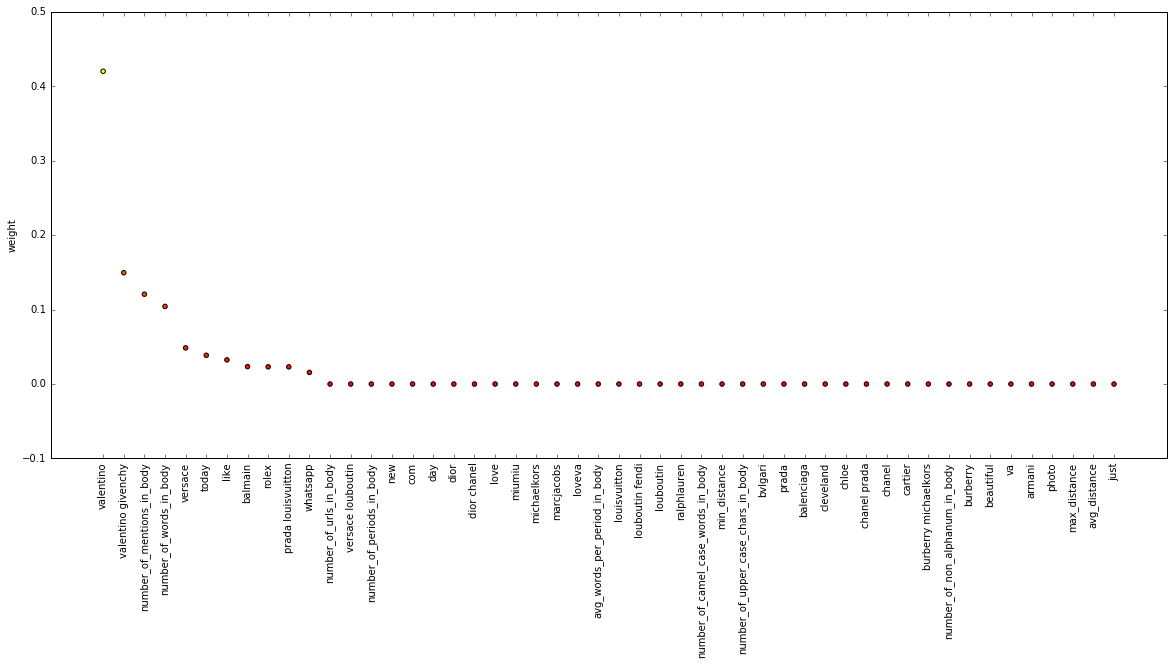

In [23]:
%pylab inline

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix

from time import time, ctime

grid_train = data.loc[:, ['body']].copy()
grid_result = data.loc[:, 'result'].values

best_pipeline = Pipeline([
  ('body_lowercase', TextToLowerCase(cols=['body'])),

  ('number_mentions', NumberOfMentions(cols=['body'])),
  ('number_hashtags', NumberOfHashtags(cols=['body'])),
  ('number_periods', NumberOfPeriods(cols=['body'])),
  ('number_urls', NumberOfURLs(cols=['body'])),

  ('number_words', NumberOfWords(cols=['body'])),
  ('number_camel_words', NumberCamelCaseWords(cols=['body'])),
  ('number_words_per_period', AvgWordsPerPeriod(cols=['body'])),        

  ('number_uppercase_chars', NumberUpperCaseChars(cols=['body'])),
  ('number_punctuation_chars', NumberNonAlphaNumChars(cols=['body'])),

  ('semantic_distance', HashtagDistanceTransformer(model, ['body'])),
    
  ("body_tfidf", DataFrameTfidfVectorizer(col='body', 
                          prefix="body",
                          ngram_range=(1, 3), 
                          analyzer="word",
                          stop_words='english',
                          binary=True, #False
                          max_features = 50)),
  ("drop_text_cols", DropColumnsTransformer(['body'])),
  ("nparray", NumpyArrayTransformer()),
  ('tree', DecisionTreeClassifier(max_depth = 5, min_samples_split = 2))
])

best_pipeline.fit(grid_train, grid_result)

features = [   u'number_of_mentions_in_body',
                u'number_of_periods_in_body',
                  u'number_of_words_in_body',
                   u'number_of_urls_in_body',
       u'number_of_camel_case_words_in_body',
             u'avg_words_per_period_in_body',
       u'number_of_upper_case_chars_in_body',
           u'number_of_non_alphanum_in_body',
                             u'avg_distance',
                             u'max_distance',
                             u'min_distance']

plot_feature_scores(best_pipeline.named_steps['tree'].feature_importances_, features + best_pipeline.named_steps['body_tfidf'].get_feature_names(), 0)

In [32]:
from sklearn.externals import joblib

model_path = "data/instagram_spam_model_20160405.pkl"
joblib.dump(best_pipeline, model_path, compress=9)

['data/instagram_spam_model_20160405.pkl',
 'data/instagram_spam_model_20160405.pkl_01.npy.z',
 'data/instagram_spam_model_20160405.pkl_02.npy.z']

In [36]:
best_pipeline.predict(pd.DataFrame([{'body': 'This is a test'}]))

Index([u'body', u'number_of_mentions_in_body', u'number_of_periods_in_body',
       u'number_of_words_in_body', u'number_of_camel_case_words_in_body',
       u'avg_words_per_period_in_body', u'number_of_upper_case_chars_in_body',
       u'number_of_non_alphanum_in_body', u'avg_distance', u'max_distance',
       u'min_distance'],
      dtype='object')


array([0])

In [25]:
trained = data.loc[:, ['body']].copy()
trained_result = data.loc[:, 'result'].values

trained.loc[:, 'predicted_result'] = best_pipeline.predict(trained)
trained.loc[:, 'result'] = data.loc[:, 'result'].values

Index([u'body', u'number_of_mentions_in_body', u'number_of_periods_in_body',
       u'number_of_urls_in_body', u'number_of_words_in_body',
       u'number_of_camel_case_words_in_body', u'avg_words_per_period_in_body',
       u'number_of_upper_case_chars_in_body',
       u'number_of_non_alphanum_in_body', u'avg_distance', u'max_distance',
       u'min_distance'],
      dtype='object')


In [33]:
#misclassifications = trained[trained['result'] != trained['predicted_result']]

print trained.groupby(['result', 'predicted_result'])['result', 'predicted_result'].agg(['count'])

                        result predicted_result
                         count            count
result predicted_result                        
0      0                   269              269
       1                    30               30
1      0                    79               79
       1                   228              228
